# CODICE PROGETTO 32 OPTIMIZATION 


### Implementazione algoritmo risolutivo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.optimize import *


# !pip install pyMCFSimplex
from pyMCFSimplex import *

#### 1. Estrazione dei dati dai file .dmx e .qfc utilizzati per la generazione delle istanze del problema
La prima funzione *matrice_Q(nome_file)* serve per estrarre i costi quadratici che si trovano nella diagonale di Q,

mentre la seconda funzione *leggi_file_dimacs(nome_file)* serve per estrarre le seguenti quantità: 
 - u, b, q
 - numero nodi
 - numero archi 

In [2]:
def matrice_Q(nome_file_qfc):
    vettore = []
    with open(nome_file_qfc, 'r') as file:
        dimensione = int(file.readline()) # la prima riga è la dimensione del vettore
        valori = file.readline().split() # dalla seconda riga 
        vettore = [float(valore) for valore in valori]
        
        #error check 
        if len(vettore) != dimensione:
            raise ValueError("Il numero di valori nel file non corrisponde alla dimensione specificata")
    
    dimensione = len(vettore)
    matrice = np.zeros((dimensione, dimensione)) # creazione matrice 
    np.fill_diagonal(matrice, vettore)  # si riempie diagonale
    
    return matrice, vettore


def leggi_file_dimacs(nome_file):
    numero_nodi = 0
    numero_archi = 0
    u = []
    b = []
    q = []
    from_=[]
    to_=[]
    edges = []

    with open(nome_file, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                if parts[0] == 'p':
                    # legge il numero di nodi e archi dal problema
                    numero_nodi = int(parts[2])
                    numero_archi = int(parts[3])
                    # inizializza il vettore di supply con zeri
                    b = [0] * numero_nodi
                elif parts[0] == 'n':
                    # legge i valori di supply per i nodi
                    nodo_id = int(parts[1])
                    supply = int(parts[2])
                    # assegna il valore di supply al nodo corrispondente
                    b[nodo_id - 1] = supply
                elif parts[0] == 'a':
                    # leggi l'arco e il suo cotso
                    from_node = int(parts[1])
                    to_node = int(parts[2])
                    max_capacity = int(parts[4])
                    costo = int(parts[5])  # leggiamo costo corretto
                    from_.append(from_node)
                    to_.append(to_node)
                    u.append(max_capacity)
                    q.append(costo)
                    edges.append((from_node , to_node ))

    return numero_nodi, numero_archi, u, b, q, edges,from_, to_

#### 2. Algoritmo

Step: 

0. Inizializzazione di x<sub>0</sub> con generazione casuale soggetta al vincolo 0 &le; x<sub>0</sub> &le; u
1. Calcolo del gradiente, risoluzione del sottoproblema lineare usando il solver pyMCFSimplex (x̄), determinazione della direzione
2. Determinazione dello step size &alpha;
3. Aggiornamento della posizione e check terminazione sul prodotto scalare (<grad, d>)

In [4]:
# Questa funzione crea un nuovo file .dmx in cui i valori delle righe che iniziano con 'a' (definizione archi)
# vengono sostituiti con i valori presenti nel vettore gradient. L'obiettivo è modificare il file di input 
# (input_file) in modo da utilizzare al posto dei costi lineari del file originale, il gradiente 
# (vogliamo risolvere il sottoproblema lineare, aka l'approssimazione lineare del problema Taylor 1st ordine).   

def modify_file_with_gradient(input_file, output_file, gradient):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # inizalizzazione dell'indice per il vettore gradient
    gradient_index = 0

    # modifica delle righe che iniziano con 'a'
    for i in range(len(lines)):
        if lines[i].startswith('a'):
            words = lines[i].split()
            words[-1] = str(gradient[gradient_index])
            gradient_index += 1
            lines[i] = ' '.join(words)

    # creazione nuovo file
    with open(output_file, 'w') as file:
        file.writelines(lines)

In [5]:
# questo codice serve per calcolare lo step size trovando alpha che minimizzi f (xk + α(dk − xk)) rispettando il vincolo 0 ≤ α ≤ 1. dove f è la nostra funzione di costo. 

# definizione della funzione quadratica - la nostra f iniziale x^TQx + q
def quadratic_function(alpha, xk, dk, Q, q):

    x_alpha = [x + alpha * (d - x) for x, d in zip(xk, dk)] 
    x_alpha = np.array(x_alpha) 

    # calcola il valore della funzione obiettivo
    return x_alpha.T @ Q @ x_alpha + q @ x_alpha


def find_optimal_alpha(xk, dk, Q, q):
   
    objective_function = lambda alpha: quadratic_function(alpha, xk, dk, Q, q) # nostra funzione obiettivo che dipende da alpha 
    result = minimize_scalar(objective_function, bounds=(0, 1), method = 'bounded') # soluzione del problema di minimo con vincolo su alpha che deve stare tra 0 e 1 

    # ritorna il valor ottimo di alpha
    return result.x


In [6]:
def showModuleFunctionality(mcf):
    vettore_soluzione = {}  
    nmx = mcf.MCFnmax()
    mmx = mcf.MCFmmax()
    pn = mcf.MCFnmax()
    pm = mcf.MCFmmax()

    pU = []
    caps = new_darray(mmx)
    mcf.MCFUCaps(caps)
    for i in range(0, mmx):
        pU.append(darray_get(caps, i))

    pC = []
    costs = new_darray(mmx)
    mcf.MCFCosts(costs)
    for i in range(0, mmx):
        pC.append(darray_get(costs, i))

    pDfct = []
    supply = new_darray(nmx)
    mcf.MCFDfcts(supply)
    for i in range(0, nmx):
        pDfct.append(darray_get(supply, i))

    pSn = []
    pEn = []
    startNodes = new_uiarray(mmx)
    endNodes = new_uiarray(mmx)
    mcf.MCFArcs(startNodes, endNodes)
    for i in range(0, mmx):
        pSn.append(uiarray_get(startNodes, i) + 1)
        pEn.append(uiarray_get(endNodes, i) + 1)

    #print("arc flow")
    length = mcf.MCFm()
    flow = new_darray(length)
    length = mcf.MCFn()
    nms = new_uiarray(length)
    mcf.MCFGetX(flow, nms)

   

    for i in range(0, length):
       # print("flow", darray_get(flow, i), "arc", uiarray_get(nms, i))
        vettore_soluzione[uiarray_get(nms, i)] = darray_get(flow, i)

    return vettore_soluzione  # Restituisci il vettore_soluzione alla fine della funzione

In [18]:
def algoritmo(nome_file, epsilon, max_iter, Q, q, u, numero_archi, f_values, step_size_ottimo):

    k = 0 
    alpha = 1 
    prodotto_scalare = float("inf")
    start_time = time.time()

    # STEP 0 : inizializzazione di x_0
    seed = 42
    np.random.seed(seed)
    x_old = []

    for u_i in u:
        x_i = random.randint(0, u_i)
        x_old.append(x_i)
    

    while  (abs(prodotto_scalare)>= epsilon and k < max_iter):
        f_x_current = np.dot(np.dot(x_old, Q), x_old) + np.dot(q, x_old)
        f_values.append(f_x_current)

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x_old)) + q
        gradient = gradient.tolist()
        modify_file_with_gradient(nome_file, 'output.dmx', gradient)

        # risoluzione del problema lineare (ricerca di argmin) con MCF solver
        FILENAME = 'output.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
        if mcf.MCFGetStatus() == 0:
            if k % 100 == 0: # stampa output ogni 100 iterazioni 
                soluzione_ottima = mcf.MCFGetFO()
                print( 'step size: ', alpha, 'iterazione: ' ,k," Optimal solution: ", soluzione_ottima)

        else:
            print( "Problem unfeasible!")
         
        vettore_soluzione = showModuleFunctionality(mcf)
     
        sol_x = [0] * numero_archi
        for key in vettore_soluzione:
            if key <= 1000:
                sol_x[key-1] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        x_bar = sol_x
        d = [a - b for a, b in zip(x_bar, x_old)] # direzione

        # STEP 2 : determinazione alpha, step size 

        if step_size_ottimo:
            alpha = find_optimal_alpha(x_old, d, Q, q)
        else:
            alpha = 2 / (2+k)

        # STEP 3 : aggiornamento della posizione
        x_new = []
        for i in range(len(x_old)):
            x_new.append(x_old[i] + alpha * d[i])

        # check terminazione 
        gradient_per_check = (2 * np.dot(Q, x_new) ) + q
        prodotto_scalare = np.dot(gradient_per_check, d)
    
        # aggiornamento poszione e incremento numero di iterazioni
        x_old = x_new
        k += 1
        
    end_time = time.time()
    tempo_tot = end_time - start_time

    print()
    print('Prodotto scalare: {:>10.2f}  Step size finale: {:>10.8f}  Numero iterazioni totali: {:>4}'.format(prodotto_scalare, alpha, k))
    print('Tempo totale: {:>10.2f} secondi'.format(tempo_tot))
    
    return f_values

In [19]:
def pipeline(nome_file_dmx, nome_file_qfc):

    Q = matrice_Q(nome_file_qfc)[0] 
    f_values = []
    
    numero_nodi, numero_archi, u, b, q, edges,from_ , to_ = leggi_file_dimacs(nome_file_dmx)
    #E = np.zeros((numero_nodi, len(edges)), int)
    #for i, (out_node, in_node) in enumerate(edges):
     #   E[out_node-1, i] = -1
      #  E[in_node-1, i] = 1

    algoritmo(nome_file_dmx, epsilon = 0.1, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, f_values = f_values, step_size_ottimo = True)
    return f_values

In [20]:
# prova di utilizzo 
valori_f = pipeline(nome_file_dmx = '1000/netgen-1000-3-5-b-b-ns.dmx', nome_file_qfc = "1000/netgen-1000-3-5-b-b-ns.qfc")

step size:  1 iterazione:  0  Optimal solution:  3690757.0

Prodotto scalare:       0.05  Step size finale: 0.99999404  Numero iterazioni totali:   18
Tempo totale:       1.81 secondi


### Studio della convergenza 


In [37]:
result_f_values = pipeline( '1000/netgen-1000-3-5-b-b-ns.dmx', "1000/netgen-1000-3-5-b-b-ns.qfc")
#print(result_f_values)  # Stampa i valori di f(x) registrati


step size:  1.0 iterazione:  0  Optimal solution: 2615517.0

Prodotto scalare:       0.03  Step size finale: 0.99999404  Numero iterazioni totali:   33
Tempo totale:       1.34 secondi


In [38]:
temp = matrice_Q('1000/netgen-1000-1-1-a-a-s.qfc')
numero_nodi, numero_archi, u, b, q, edges,from_ , to_ = leggi_file_dimacs('1000/netgen-1000-1-1-a-a-s.dmx')
Q = temp[0]
Q_diag = temp[1]

In [39]:
# l'autovalore massimo di Q è la costante L
L = np.max(Q_diag)
# il diametro dello spazio  è la norma del vettore u 
D = np.linalg.norm(u)

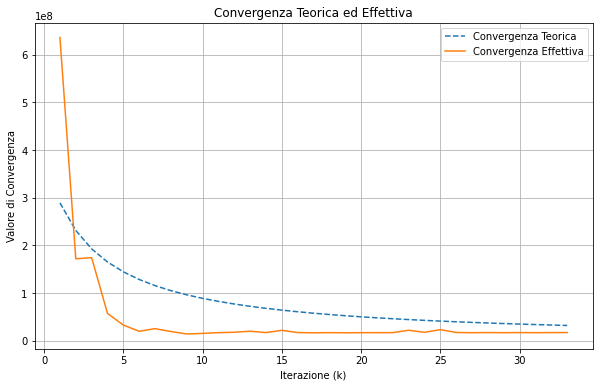

In [42]:
k_max = 33 # numero massimo di iterazioni

# inizializzazione delle liste per i dati
k_values = []  # valori di k (iterazione)
convergence_values = []  # valori di convergenza teorica
f_values = result_f_values

# Simula i dati teorici (convergenza teorica)
for k in range(1, k_max + 1):
    k_values.append(k)
    convergence_values.append((2 * L * D**2) / (k + 3))


# crea il grafico
plt.figure(figsize=(10, 6))
plt.plot(k_values, convergence_values, label="Convergenza Teorica", linestyle='--')
plt.plot(k_values, f_values, label="Convergenza Effettiva", linestyle='-')

plt.xlabel("Iterazione (k)")
plt.ylabel("Valore di Convergenza")
plt.legend()
plt.title("Convergenza Teorica ed Effettiva")
plt.grid(True)

# Mostra il grafico
plt.show()
